# The Stock Price Relationship between Apple Inc. and Foxconn
B036060017 資管系四年級 謝威廷, 2018/3/31 

## Introduction
主要是預測鴻海的收盤價的漲跌，輸入的資料沒限定，可以是之前的蘋果公司和鴻海股票的任何資訊(如開盤價,收盤價,成交量...)
1. Data Preprocessing


## 1. Data Preprocessing
- Load the Apple and Foxconn stock dataset.
- Preprocess the `Date` and `Volume` column.
    - Format `Date` to datetime
    - Adjust `Volume` of Apple and Foxconn to same units
- Remove the outlier in foxconn dataset.
- Align the datetime, and combine above two input source into one dataset.

### 1.1 Apple Stock

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
colnames = ['Date', 'Open_A', 'High_A', 'Low_A', 'Close_A', 'Volume_A']

apple = pd.read_csv('apple.csv', encoding = 'utf-8', parse_dates=True)
apple.columns = colnames
apple['Date'] = pd.to_datetime(apple['Date'], format = '%Y/%m/%d')

In [3]:
import re

volume_list = []

# Convert million and million to actual number 
pattern = re.compile(".*[B]")
for i in apple['Volume_A'].values:
    if pattern.match(i):
        i = i.replace(r'.', '').replace(r'B', '00000000')
        volume_list.append(i)
    else:
        i = i.replace(r'.', '').replace(r'M', '000000')
        volume_list.append(i)

apple['Volume_A'] = volume_list

print("Apple Stock : ", apple.shape)
apple.head()

Apple Stock :  (6926, 6)


,Date,Open_A,High_A,Low_A,Close_A,Volume_A
0,1990-01-02,1.3304,1.3393,1.2500,1.3304,4580000000
1,1990-01-03,1.3393,1.3571,1.3393,1.3393,5200000000
2,1990-01-04,1.3437,1.3839,1.3304,1.3437,5538000000
3,1990-01-05,1.3482,1.3661,1.3214,1.3482,3083000000
4,1990-01-08,1.3571,1.3571,1.3214,1.3571,2539000000


### 1.2 Foxconn Stock

In [4]:
colnames = ['Date', 'Open_F', 'High_F', 'Low_F', 'Close_F', 'Volume_F']

foxconn = pd.read_csv('foxconn.csv', encoding = 'utf-8', parse_dates=True)
foxconn.columns = colnames
foxconn['Date'] = pd.to_datetime(foxconn['Date'], format = '%Y/%m/%d')

# Drop out the first 10 row, because the volume seems weird
foxconn = foxconn.drop(foxconn.index[0:10])
print("Foxconn Stock : ", foxconn.shape)
foxconn.head()

Foxconn Stock :  (6751, 6)


,Date,Open_F,High_F,Low_F,Close_F,Volume_F
10,1991-06-29,85.5,85.5,85.5,85.5,2221
11,1991-07-02,89.0,89.0,82.5,82.5,2670
12,1991-07-03,82.0,82.5,80.0,82.0,1298
13,1991-07-04,80.5,87.5,80.5,87.5,1880
14,1991-07-05,88.0,89.0,85.0,88.0,2475


### 1.3 Combine Dataset
- Taiwan stock market is influenced by the last day of US stock market
- In order to combine two different stock data, needs to minus US stock datetime by one day.
- Last, only left 4993 valid row data after data preprocessing stage.

In [5]:
from datetime import datetime, timedelta

# Minus Apple stock datetime one day
apple['Date'] = apple['Date'] - timedelta(days=1)
 
# Choose the same period with foxconn
start_date = foxconn.iloc[0, 0]
end_date = foxconn.iloc[-1, 0]

mask = (apple['Date'] >= start_date) & (apple['Date'] <= end_date)
apple = apple.loc[mask]

stock = pd.merge(apple, foxconn, on = 'Date', how = 'inner', indicator = True)
print("Stock size after merge : ", stock.shape)
stock.head()

Stock size after merge :  (4993, 12)


,Date,Open_A,High_A,Low_A,Close_A,Volume_A,Open_F,High_F,Low_F,Close_F,Volume_F,_merge
0,1991-07-02,1.5402,1.5536,1.4911,1.5402,7619000000,89.0,89.0,82.5,82.5,2670,both
1,1991-07-04,1.6295,1.6429,1.5268,1.6295,8289000000,80.5,87.5,80.5,87.5,1880,both
2,1991-07-08,1.6741,1.7232,1.6607,1.6741,5661000000,83.0,86.0,82.0,82.0,1018,both
3,1991-07-09,1.6875,1.7232,1.6696,1.6875,3914000000,83.0,83.5,80.5,82.0,675,both
4,1991-07-10,1.6696,1.6875,1.6429,1.6696,3648000000,83.5,84.0,82.0,84.0,690,both


In [6]:
stock_final = stock.iloc[:, np.r_[1:5, 9]]
stock_final.head()

,Open_A,High_A,Low_A,Close_A,Close_F
0,1.5402,1.5536,1.4911,1.5402,82.5
1,1.6295,1.6429,1.5268,1.6295,87.5
2,1.6741,1.7232,1.6607,1.6741,82.0
3,1.6875,1.7232,1.6696,1.6875,82.0
4,1.6696,1.6875,1.6429,1.6696,84.0


### 1.4 Split the Training and Test dataset

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stock_final.iloc[:, :-1], stock_final.iloc[:, -1],
                                                    test_size = 0.2, random_state = 10)
print("X_train Shape : ", X_train.shape, ", X_test Shape : ", X_test.shape)

X_train Shape :  (3994, 4) , X_test Shape :  (999, 4)


## 2. Model Construction
### 2.1 Linear Regression Pipeline
- In the first trial, we achieved **MSE score 3190.565 as Baseline Benchmark**.
- Proposed further advanced techniques to see whether enhance the performance metrics or not.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('reg', LinearRegression())])
pipe_lr.fit(X_train, y_train)

score_mse_lr = cross_val_score(estimator = pipe_lr,
                               X = X_train,
                               y = y_train,
                               cv = 10,
                               scoring = "neg_mean_squared_error",
                               n_jobs = -1)
predict_lr = pipe_lr.predict(X_test)

print("CV MSE Scores : %.3f +/- %.3f" %(np.negative(np.mean(score_mse_lr)), np.std(score_mse_lr)))
print("Test MSE %.3f" %mean_squared_error(y_test, predict_lr))

/Users/kennyhsieh/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


CV MSE Scores : 3190.565 +/- 307.050
Test MSE 3060.323


## 3. Feature Engineering
### 3.1 Create Gap Ratio in Single Day Feature
$$Gap \;Ratio = \frac{Close\; - \; Open}{Close}$$

In [9]:
# Gap Ratio
stock_final.loc[:, "GapRation"] = (stock_final.Close_A - stock_final.Open_A)/stock_final.Close_A
stock_final.head()

,Open_A,High_A,Low_A,Close_A,Close_F,GapRation
0,1.5402,1.5536,1.4911,1.5402,82.5,0.0
1,1.6295,1.6429,1.5268,1.6295,87.5,0.0
2,1.6741,1.7232,1.6607,1.6741,82.0,0.0
3,1.6875,1.7232,1.6696,1.6875,82.0,0.0
4,1.6696,1.6875,1.6429,1.6696,84.0,0.0


### 3.2 Create Return Feature
$$Return = \ln(\frac{Close_{t}}{Close_{t-1}})$$

In [10]:
# Return
return_list = []

for i in range(stock_final.shape[0]-1):
    ret = np.log(stock_final.iloc[i, 3] / stock_final.iloc[i+1, 3])
    return_list.append(ret)

## Delete the fist row that can't calculate Return
stock_final = stock_final.iloc[1:, :]
stock_final["Return"] = return_list

## Alter the column order
cols = stock_final.columns.tolist()
cols = cols[:4] + cols[5:] + cols[4:5]
stock_final = stock_final[cols]
stock_final.head()

,Open_A,High_A,Low_A,Close_A,GapRation,Return,Close_F
1,1.6295,1.6429,1.5268,1.6295,0.0,-0.056361,87.5
2,1.6741,1.7232,1.6607,1.6741,0.0,-0.027002,82.0
3,1.6875,1.7232,1.6696,1.6875,0.0,-0.007972,82.0
4,1.6696,1.6875,1.6429,1.6696,0.0,0.010664,84.0
5,1.6696,1.6875,1.6518,1.6696,0.0,0.000000,82.0


### 3.3 Split the new dataset after feature engineering

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stock_final.iloc[:, :-1], stock_final.iloc[:, -1],
                                                    test_size = 0.2, random_state = 10)
print("X_train Shape : ", X_train.shape, ", X_test Shape : ", X_test.shape)

X_train Shape :  (3993, 6) , X_test Shape :  (999, 6)


## 4. More Robust Model Construction
- Compare with original Linear Regression to observe whether feature engineering is useful.
- Construct with ensemble method model, i.e. Random Forest

### 4.1 The Effort of Feature Engineering
- Slight improvement on Test MSE, thus feature engineering do work!

In [12]:
pipe_lr.fit(X_train, y_train)

score_mse_lr = cross_val_score(estimator = pipe_lr,
                               X = X_train,
                               y = y_train,
                               cv = 10,
                               scoring = "neg_mean_squared_error",
                               n_jobs = -1)

predict_lr_fe = pipe_lr.predict(X_test)

print("CV MSE Scores : %.3f +/- %.3f" %(np.negative(np.mean(score_mse_lr)), np.std(score_mse_lr)))
print("Test MSE Scores : %.3f" %mean_squared_error(y_test, predict_lr_fe))

CV MSE Scores : 3210.573 +/- 234.080
Test MSE Scores : 2992.890


### 4.2 Ensemble Method : Random Forest
- Significant improvement !!!

In [13]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('reg', RandomForestRegressor(n_estimators = 500, random_state = 10))])
pipe_rf.fit(X_train, y_train)

score_mse_rf = cross_val_score(estimator = pipe_rf,
                               X = X_train,
                               y = y_train,
                               cv = 10,
                               scoring = "neg_mean_squared_error",
                               n_jobs = -1)

predict_rf = pipe_rf.predict(X_test)

print("CV MSE Scores : %.3f +/- %.3f" %(np.negative(np.mean(score_mse_rf)), np.std(score_mse_rf)))
print("Test MSE Scores : %.3f" %mean_squared_error(y_test, predict_rf))

CV MSE Scores : 2039.792 +/- 224.142
Test MSE Scores : 1658.978


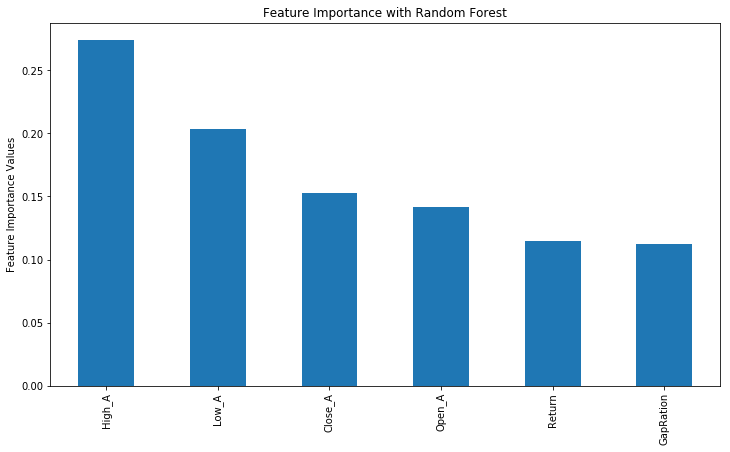

In [14]:
imp_features = pd.Series(pipe_rf.steps[1][1].feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_features.plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance Values')
plt.subplots_adjust(bottom=0.25)
plt.show()

## 5. Conslusion
- Observe the prediction made by each model

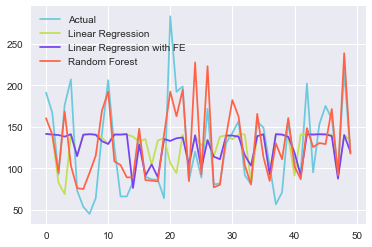

In [38]:
range_num = 5

plt.plot(y_test.values[:range_num], color = '#6dc9dd', label = "Actual")
plt.plot(predict_lr[:range_num], color = '#c2df55', label = 'Linear Regression')
plt.plot(predict_lr_fe[:range_num], color = '#7741f4', label = 'Linear Regression with FE')
plt.plot(predict_rf[:range_num], color = '#ff6347', label = "Random Forest")

plt.legend()

### * Appedix : Mismatch Date Observation

In [16]:
total = pd.merge(apple, foxconn, on = 'Date', how = 'outer', indicator = True)
total['_merge'].value_counts()

both          4993
right_only    1758
left_only     1555
Name: _merge, dtype: int64

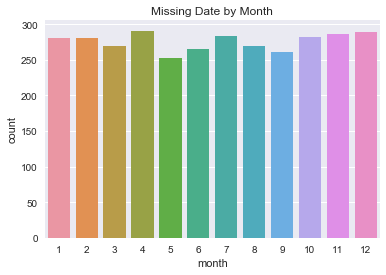

In [17]:
diff_time = total.query('_merge != "both"')
diff_time['month'] = diff_time.loc[:, 'Date'].dt.month

sns.set(style="darkgrid")
ax = sns.countplot(x="month", data=diff_time).set_title('Missing Date by Month')